# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [95]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

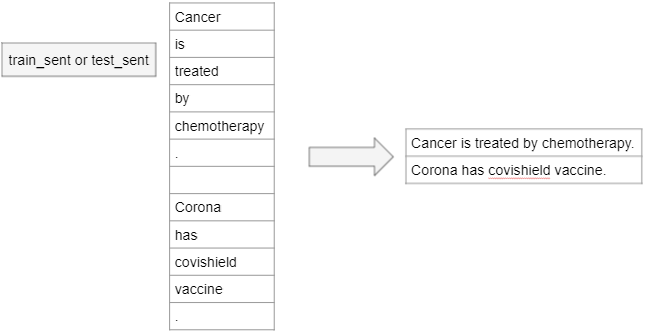

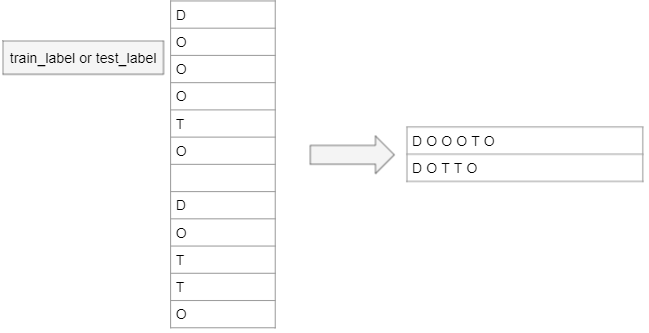

In [96]:
def readfile(path):
  textcorpus=[]
  with open(path,'r') as file_:
    textcorpus=file_.readlines()
  sentences=[]
  sentence=[]
  for i  in range(len(textcorpus)):
      if textcorpus[i]=='\n':
        sentences.append(' '.join(sentence))
        sentence.clear()
        continue
      sentence.append(textcorpus[i].rstrip('\n'))
  return sentences

In [97]:
train_sent_text=readfile('/content/train_sent')
test_sent_text=readfile('/content/test_sent')
train_label_text=readfile('/content/train_label')
test_label_text=readfile('/content/test_label')

In [98]:
print(train_label_text[25])
print(train_sent_text[25])



O D O O O O O
Severe preeclampsia was defined by standard criteria


### Count the number of sentences in the processed train and test dataset 

In [99]:
print(len(train_sent_text))
print(len(test_sent_text))

2599
1056


### Count the number of lines of labels in the processed train and test dataset.

In [100]:
print(len(train_label_text))
print(len(test_label_text))

2599
1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [101]:
nlp=spacy.load('en_core_web_sm')
noun_dict={}
for sent in train_sent_text:
  tokens=nlp(sent)
  for token in tokens:
    if token.pos_ =='NOUN'or token.pos_=='PROPN':
      if noun_dict.get( token.text,"NA")=='NA':
        noun_dict[token.text] =1
      else:
        noun_dict[token.text]+=1


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [102]:
sorted_nounlist=sorted(noun_dict.items(),key=lambda x : x[1],reverse=True)

In [103]:
print(sorted_nounlist[:25])

[('patients', 354), ('treatment', 195), ('%', 161), ('cancer', 135), ('therapy', 120), ('disease', 105), ('study', 101), ('cell', 99), ('lung', 87), ('chemotherapy', 65), ('group', 63), ('effects', 61), ('gene', 54), ('use', 53), ('results', 53), ('surgery', 51), ('survival', 50), ('risk', 49), ('women', 48), ('care', 47), ('analysis', 47), ('children', 47), ('activity', 47), ('rate', 46), ('cases', 46)]


## Defining features for CRF





In [104]:
#we will check the dependency tags and words in sentences individually to get feature functions which
#can give maximum information about diseases and treatments from parsed sentences
nlp=spacy.load('en_core_web_sm')
for i in range(100):
  if 'D' in train_label_text[i] or 'T' in train_label_text[i]:
    found_index=i
    print(train_sent_text[found_index])
    print(train_label_text[found_index])
    tokens=nlp(train_sent_text[found_index])
    for token in tokens:
      print(token.pos_,'--',token.text,'--',token.dep_,'--',token.ent_iob_)

    




The study population included 84 women with gestational diabetes , ascertained by universal screening of all women attending the antenatal clinic of the Hadassah Medical Center , over a 2-year period
O O O O O O O D D O O O O O O O O O O O O O O O O O O O O O O
DET -- The -- det -- O
NOUN -- study -- compound -- O
NOUN -- population -- nsubj -- O
VERB -- included -- ROOT -- O
NUM -- 84 -- nummod -- B
NOUN -- women -- dobj -- O
ADP -- with -- prep -- O
ADJ -- gestational -- amod -- O
NOUN -- diabetes -- pobj -- O
PUNCT -- , -- punct -- O
VERB -- ascertained -- advcl -- O
ADP -- by -- agent -- O
ADJ -- universal -- amod -- O
NOUN -- screening -- pobj -- O
ADP -- of -- prep -- O
DET -- all -- det -- O
NOUN -- women -- pobj -- O
VERB -- attending -- acl -- O
DET -- the -- det -- O
ADJ -- antenatal -- amod -- O
NOUN -- clinic -- dobj -- O
ADP -- of -- prep -- O
DET -- the -- det -- B
PROPN -- Hadassah -- compound -- I
PROPN -- Medical -- compound -- I
PROPN -- Center -- pobj -- I
PUNCT -- ,

From above analysis we can see the Treatment or diseas might be following transition of
1. POS( adj->noun) and labeled as T or D
2. (PROPN->NOUN) and labeled as T or D
3. only NOUN and labeled as T or D

The features can be defined as follows<BR>
F1(X, xi, xi-1, i) = 1 if xi is a NOUN  and xi-1 is an ADJ and xi is labeled as D or T
 ; otherwise, 0.<BR>
F2(X, xi, xi-1, i) = 1 if xi is a NOUN and xi-1 is a PROPN and xi is labeled as D or T ;otherwise, 0.<BR>
F3(X, xi, xi-1, i) = 1, if xi is NOUN and and xi is labeled as D or T ;
otherwise ,0.


In [105]:
nlp=spacy.load('en_core_web_sm')
def getfeatureperoneword(sentence,label,pos):
    lis_words=sentence.split()
    lis_label=label.split()
    pos_tags=[]
    feature=[]
    if pos==0:
      feature.append('BEG')
    feature.append('word:lower='+lis_words[pos].lower())

    
    if len(lis_words)>1:
      tokens=nlp(sentence)
      for token in tokens:
        pos_tags.append(token.pos_)

        #print(token.pos_)

      #print(pos_tags)
      if pos>0:
        if tokens[pos].pos_=='NOUN' and (lis_label[pos]=="D" or lis_label[pos]=="T"):
           feature.append('word:nounwithDorT ='+str(True))
        else:
           feature.append('word:nounwithDorT ='+str(False))

        if  pos_tags[pos-1] =='ADJ' and pos_tags[pos] =='NOUN' and (lis_label[pos]=="D" or lis_label[pos]=="T"):
          feature.append('word:nounwithDorTandpreADJ='+str(True))
        else:
          feature.append('word:nounwithDorTandpreADJ='+str(False))

        if  pos_tags[pos-1] =='PROPN' and pos_tags[pos] =='NOUN' and (lis_label[pos]=="D" or lis_label[pos]=="T"):
          feature.append('word:nounwithDorTandprePROPN='+str(True))
        else:
          feature.append('word:nounwithDorTandprePROPN='+str(False))
      else:
        if tokens[0].pos_=='NOUN' and (lis_label[0]=="D" or lis_label[0]=="T"):
           feature.append('word:nounwithDorT ='+str(True))
        else:
           feature.append('word:nounwithDorT ='+str(False))
        feature.append('word:nounwithDorTandpreADJ='+str(False))
        feature.append('word:nounwithDorTandprePROPN='+str(False))
   
    if pos==len(lis_words)-1:
      feature.append('END')
    return feature

## Getting the features

### Write a code/function to get the features for a sentence

In [106]:

getfeatureperoneword(train_sent_text[0],test_label_text[0],0) 

['BEG',
 'word:lower=all',
 'word:nounwithDorT =False',
 'word:nounwithDorTandpreADJ=False',
 'word:nounwithDorTandprePROPN=False']

In [107]:
# Write a code to get features for a sentence.
def getfeaturesforsentence(sentences,labels,i):
  return [getfeatureperoneword(sentences[i],labels[i],j) for j in range(len(sentences[i].split()))]

In [108]:
print(train_sent_text[25])
print(train_label_text[25])
getfeaturesforsentence(train_sent_text,train_label_text,25)

Severe preeclampsia was defined by standard criteria
O D O O O O O


[['BEG',
  'word:lower=severe',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=preeclampsia',
  'word:nounwithDorT =True',
  'word:nounwithDorTandpreADJ=True',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=was',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=defined',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=by',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=standard',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False'],
 ['word:lower=criteria',
  'word:nounwithDorT =False',
  'word:nounwithDorTandpreADJ=False',
  'word:nounwithDorTandprePROPN=False',
  'END']]

## Define the labels as the target variable for test and the train dataset

In [109]:
X_train=[getfeaturesforsentence(train_sent_text,train_label_text,i)  for i in range(len(train_sent_text))]
Y_train=[getfeaturesforsentence(test_sent_text,test_label_text,i)  for i in range(len(test_sent_text))]


In [110]:
X_train

[[['BEG',
   'word:lower=all',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=live',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=births',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=>',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=or',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower==',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=23',
   'word:nounwithDorT =False',
   'word:nounwithDorTandpreADJ=False',
   'word:nounwithDorTandprePROPN=False'],
  ['word:lower=weeks',
   'word:nounwithDorT =False',
   'wor

### Write a code/function to get the labels of a sentence

In [111]:
# Write a code to get the labels for a sentence.
X_test=[train_label_text[i].split() for i in range(len(train_label_text))]
y_test=[test_label_text[i].split() for i in range(len(test_label_text))]

In [112]:
X_test

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O',
 

## Build the CRF Model

In [113]:
crf=sklearn_crfsuite.CRF(max_iterations=100)
try:
  crf.fit(X_train,X_test)
except AttributeError:
  pass

### Evaluation

In [116]:
Y_pred=crf.predict(Y_train)
metrics.flat_f1_score(y_test, Y_pred, average='weighted')

0.9382670383044749

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

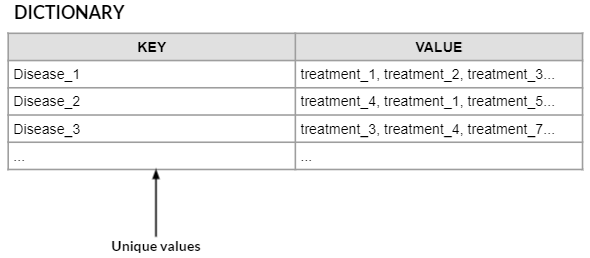

In [135]:
diseasemap_dict={}
for i in range(len(Y_pred)):
  sentence=Y_train[i]
  labels=Y_pred[i]

  if 'D' in labels and 'T' in labels:
   # print(labels)
    diseases=[]
    treatments=[]
    for j in range(len(labels)):
      if labels[j]=='D':
          diseases.append(sentence[j])
      elif labels[j]=='T':
           treatments.append(sentence[j])
    if len(diseases)>1 and len(treatments)>1:
      diseasesent=''
      treatmentsent=''
      for d in diseases:
        diseasesent += (d[0][len('word:lower='):])+" "
      for t in treatments:
        treatmentsent += (t[0][len('word:lower='):])+" "
      print(diseasesent.rstrip(),'--',treatmentsent.rstrip())
      diseasemap_dict[diseasesent.rstrip()]=treatmentsent.rstrip()
diseasemap_dict

myocardial infarction -- aspirin , 3 mg warfarin with 80 mg aspirin , or 1 mg warfarin with 80 mg aspirin
myofascial trigger point pain -- muscle tightness
rheumatoid arthritis --  arthrodesis
early parkinson 's disease --  monotherapy
stress urinary incontinence -- surgical procedures
stress urinary incontinence -- surgical treatment
preeclampsia preeclampsia -- partner insemination donor insemination
major pulmonary embolism -- thrombolytic treatment
heart failure chronic pulmonary disease ( p=.032 ) -- syncope ( p=.012 ) , arterial hypotension ( p=.021 )
malignant pleural mesothelioma -- thoracotomy , radiotherapy , and chemotherapy
dysfunction dysfunction -- thyroid hormone systems
stone disease --  treatment
colorectal cancer --  surgery
 splenic rupture -- colony-stimulating factor ( g-csf )
major pulmonary embolism -- thrombolytic treatment
colorectal cancer -- curative surgery
acute respiratory distress syndrome -- ventilation strategy to prevent barotrauma
's syndrome -- lapar

{' splenic rupture': 'colony-stimulating factor ( g-csf )',
 "'s esophagus": ' suppression therapy',
 "'s syndrome": 'laparoscopic cholecystectomy',
 'acute cerebral ischemia': ' therapy',
 'acute myocardial infarction': 'thrombolytic treatment',
 'acute respiratory distress syndrome': 'ventilation strategy to prevent barotrauma',
 'advanced disease prior': 'resection , allowing neoadjuvant therapy',
 'advanced non -- small-cell lung cancer': 'paclitaxel plus carboplatin ( pc ) offered a survival advantage over vinorelbine plus cisplatin ( vc )',
 'advanced non-small-cell lung cancer ( la-nsclc )': 'chemotherapy and radiotherapy )',
 'advanced rectal cancer': ' surgery',
 'advanced renal cell carcinoma': 'interferon alpha preparations , including interferons',
 'advanced stage': 'combination chemotherapy program consisting of bleomycin and methotrexate weekly , doxorubicin every 3 weeks , and topical nitrogen mustard daily ( bam-m )',
 'atopic dermatitism': 'tacrolimus and ascomycin de

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [141]:
diseasemap_dict.get('hereditary retinoblastoma','Suitable treatment not found  please refer to external sources')

'Suitable treatment not found  please refer to external sources'

## Predict the treatment for the disease name: 'lung carcinoma lung'

In [142]:
diseasemap_dict.get('lung carcinoma lung','Suitable treatment not found  please refer to external sources')

'lobectomy or partial resection'